In [95]:
%pip install matplotlib pandas duckdb


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python3.12 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


<br><br><br>

# [LA] Issued Building Permits: Read and Merge

All 3 of these datasets need to be combined:

* [LADBS - Building Permits Issued from 2020 to Present (N)](https://data.lacity.org/City-Infrastructure-Service-Requests/Building-and-Safety-Building-Permits-Issued-from-2/pi9x-tg5x/about_data "Building and Safety - Building Permits Issued from 2020 to Present (N) | Los Angeles - Open Data Portal")
* [LADBS - Building Permits Issued Between 2010 and 2019 (N)](https://data.lacity.org/City-Infrastructure-Service-Requests/Building-and-Safety-Building-Permits-Issued-Betwee/dyxf-7hc4/about_data "Building and Safety - Building Permits Issued Between 2010 and 2019 (N) | Los Angeles - Open Data Portal")
* [LADBS - Building Permits Issued Before 2010 (N)](https://data.lacity.org/City-Infrastructure-Service-Requests/Building-and-Safety-Building-Permits-Issued-Before/e67z-kt2n/about_data "Building and Safety - Building Permits Issued Before 2010 (N) | Los Angeles - Open Data Portal")

Fortunately, they share the same columns, so merging is straightforward using `pd.concat()`.


In [39]:
import pandas as pd
import duckdb

file_paths = [
    'input/los_angeles/Building_and_Safety_-_Building_Permits_Issued_Before_2010__N__20250810.csv',
    'input/los_angeles/Building_and_Safety_-_Building_Permits_Issued_Between_2010_and_2019__N__20250810.csv',
    'input/los_angeles/Building_and_Safety_-_Building_Permits_Issued_from_2020_to_Present__N__20250810.csv',
]
date_fields = ['SUBMITTED_DATE', 'ISSUE_DATE', 'COFO_DATE', 'STATUS_DATE']
permits_lacity_base = pd.concat(
    (pd.read_csv(f, parse_dates=date_fields) for f in file_paths),
    ignore_index=True,
)
permits_lacity_base['issue_year'] = permits_lacity_base['ISSUE_DATE'].dt.year
print(permits_lacity_base.dtypes)

/tmp/ipykernel_703755/3420184732.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  (pd.read_csv(f, parse_dates=date_fields) for f in file_paths),
/tmp/ipykernel_703755/3420184732.py:11: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  (pd.read_csv(f, parse_dates=date_fields) for f in file_paths),


PERMIT_NBR                 object
PRIMARY_ADDRESS            object
ZIP_CODE                  float64
CD                        float64
PIN_NBR                    object
APN                        object
ZONE                       object
APC                        object
CPA                        object
CNC                        object
HL                         object
CT                         object
PERMIT_GROUP               object
PERMIT_TYPE                object
PERMIT_SUB_TYPE            object
USE_CODE                  float64
USE_DESC                   object
SUBMITTED_DATE     datetime64[ns]
ISSUE_DATE         datetime64[ns]
COFO_DATE          datetime64[ns]
DU_CHANGED                float64
ADU_CHANGED               float64
JUNIOR_ADU                float64
SQUARE_FOOTAGE            float64
STATUS_DESC                object
STATUS_DATE                object
VALUATION                 float64
CONSTRUCTION               object
HEIGHT                    float64
TYPE_LAT_LON  

<br><br><br>

# [LA] Annotate permits with ADU hints:

* `certainly_adu` - explicitly marked as an ADU via `use_desc` code.
* `probably_adu` - only marked using a residential-type code, but the long description clearly indicates that it is for an ADU.

In [40]:
sql_string = """
with annotated as (
  SELECT *,

       use_desc in (
         'Accessory Dwelling Unit',
         'Junior Accessory Dwelling Unit'
       ) and not (
            work_desc ilike '%supplemental%'
         or work_desc ilike '%suppl.%'
         or work_desc ilike '%suppl to%'
       ) as certainly_adu,
    
       use_desc in (
         'Apartment',
         'Duplex',
         'Dwelling - Single Family',
         'Garage - Private'
       ) and (
            work_desc ilike '%(n) adu%'
         or work_desc ilike '%new adu%'
         or work_desc ilike '%one adu%'
         or work_desc ilike '%(n) (% sf) adu%'
         or work_desc ilike '%new (% sf) adu%'
         or work_desc ilike '%one (% sf) adu%'
         or work_desc ilike '%(n) accessory dwelling unit%'
         or work_desc ilike '%new accessory dwelling unit%'
         or work_desc ilike '%one accessory dwelling unit%'
         or work_desc ilike '%(n) (% sf) accessory dwelling unit%'
         or work_desc ilike '%new (% sf) accessory dwelling unit%'
         or work_desc ilike '%one (% sf) accessory dwelling unit%'
       ) and not (
            work_desc ilike '%supplemental%'
         or work_desc ilike '%suppl.%'
         or work_desc ilike '%suppl to%'
       ) as probably_adu,

       (
            regexp_matches(work_desc, '.*pre-approved (standard|std) plan.*', 'i')
         or regexp_matches(work_desc, '.*pre-approved (detacted |)(accessory dwelling unit|adu).*', 'i')
         or (
           regexp_matches(work_desc, '.*(city|ladbs) (standard|std) plan.*', 'i')
           and not work_desc ilike '%spiral staircase%'
         )
         or regexp_matches(work_desc, '.*(city|ladbs) (standard|std) adu plan.*', 'i')
         or regexp_matches(work_desc, '.*(city|ladbs) adu([0-9]|[0-9][0-9]) (standard|std|approved|pre-approved) plan.*', 'i')
         or regexp_matches(work_desc, '.*(accessory dwelling unit|adu).*pre-approved plan.*', 'i')
         or work_desc ilike '%you-adu%'
         or work_desc similar to '.*adu([0-9]|[0-9][0-9])[, ].*'
       ) as smells_preapproved
    
  FROM permits_lacity_base
)
select *,
       (certainly_adu or probably_adu) as is_adu,
       (certainly_adu or probably_adu) and smells_preapproved as is_preapproved_adu
from annotated
"""

permits_lacity = duckdb.query(sql_string).df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

<br><br><br>

# [LA] How many ADU permits use pre-approved plans? .

   issue_year  lacity_custom_adus  lacity_preapproved_adus
0        2017              1714.0                      1.0
1        2018              3621.0                      1.0
2        2019              4100.0                      5.0
3        2020              2740.0                      0.0
4        2021              3943.0                      1.0
5        2022              5364.0                      8.0
6        2023              4404.0                      6.0
7        2024              4376.0                      3.0
8        2025              2861.0                      2.0


<Axes: xlabel='issue_year'>

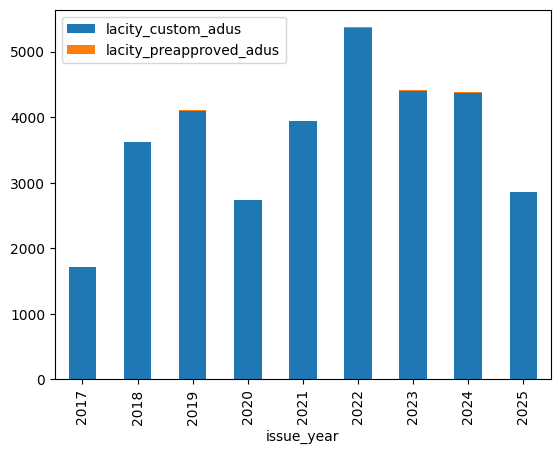

In [41]:
sql_string = """
  SELECT issue_year,
         sum(not is_preapproved_adu) as lacity_custom_adus,
         sum(is_preapproved_adu) as lacity_preapproved_adus,
    FROM permits_lacity
   WHERE is_adu
     and issue_year >= 2017
group by issue_year
order by issue_year
"""

lacity_adu_permits_issued_by_preapproved_by_year = duckdb.query(sql_string).df()
print(lacity_adu_permits_issued_by_preapproved_by_year)
lacity_adu_permits_issued_by_preapproved_by_year.plot(
    x='issue_year',
    y=['lacity_custom_adus', 'lacity_preapproved_adus'],
    kind='bar',
    stacked=True,
)

<br><br><br>

# [LA] Try to identify trends between certainly/probably ADUs.

<Axes: xlabel='issue_year'>

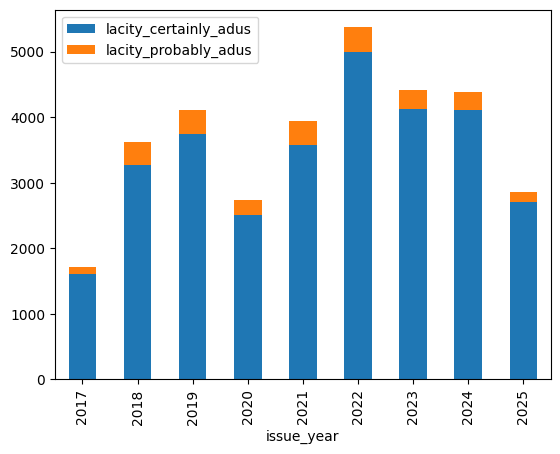

In [6]:
sql_string = """
  SELECT issue_year,
         sum(certainly_adu) as lacity_certainly_adus,
         sum(probably_adu) as lacity_probably_adus,
         sum(certainly_adu) + sum(probably_adu) as lacity_all_adus
    FROM permits_lacity
   WHERE (certainly_adu or probably_adu)
     AND issue_year >= 2017
group by issue_year
order by issue_year
"""

lacity_adu_permits_issued_by_year = duckdb.query(sql_string).df()
lacity_adu_permits_issued_by_year.plot(x='issue_year', y=['lacity_certainly_adus', 'lacity_probably_adus'], kind='bar', stacked=True)

<Axes: xlabel='issue_year'>

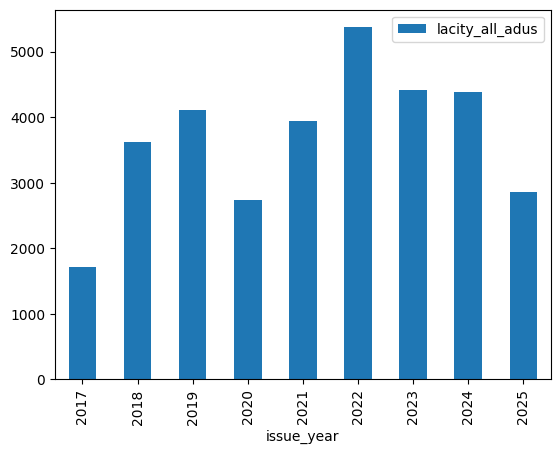

In [115]:
lacity_adu_permits_issued_by_year.plot(x='issue_year', y=['lacity_all_adus'], kind='bar')

<br><br><br>

# [LA + Sac] Early comparison of issued ADU permits

Sacramento city staff published historic annual counts for ADU permits issued in their [2024 Housing Element Annual Progress Report](https://sacramento.granicus.com/MetaViewer.php?view_id=21&event_id=5356&meta_id=820912#page=7). Assuming these numbers are comparable to mine for LA, then plotting the two cities side-by-side could be useful. 

<Axes: xlabel='issue_year'>

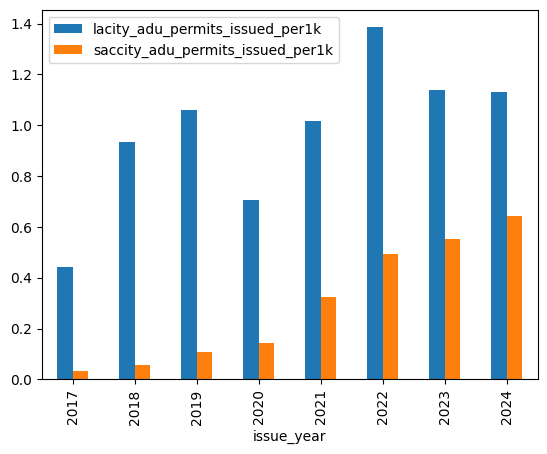

In [120]:
##############################
# Copy Sac data from report. #
##############################
saccity_adu_permits_issued = pd.DataFrame(
    data={
      'issue_year': [2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024],
      'saccity_all_adus': [18, 30, 57, 76, 170, 259, 291, 338],
    },
)
all_cities_adu_permits_issued_by_year = lacity_adu_permits_issued_by_year.merge(saccity_adu_permits_issued)

############################
# Normalize by population. #
############################
lacity_population = 3878704
saccity_population = 526327

all_cities_adu_permits_issued_by_year['lacity_adu_permits_issued_per1k'] = (
    all_cities_adu_permits_issued_by_year['lacity_all_adus'] / lacity_population * 1000
)
all_cities_adu_permits_issued_by_year['saccity_adu_permits_issued_per1k'] = (
    all_cities_adu_permits_issued_by_year['saccity_all_adus'] / saccity_population * 1000
)

#########
# Plot. #
#########
all_cities_adu_permits_issued_by_year.plot(
    x='issue_year',
    y=['lacity_adu_permits_issued_per1k', 'saccity_adu_permits_issued_per1k'],
    kind='bar'
)

<br><br><br>

# Los Angeles Issued ADU Permits: Sample Descriptions

Permit descriptios could contain the clues needed to identify Los Angeles ADU permits using pre-approved plans (vs. non-pre-approved).

Unfortunately, I can't find any pattern in the noise. Sacramento building department staff do better job at including certain key words like "shelf-ready ADU" in their descriptions.

In [43]:
sql_string = """
SELECT year("ISSUE_DATE") as issue_year, use_desc, work_desc
FROM permits_lacity
WHERE is_adu and not is_preapproved_adu
"""

adu_permits_issued_digging = duckdb.query(sql_string).df()
with pd.option_context('display.max_rows', 100, 'display.max_columns', None, 'display.max_colwidth', 200):
    if len(adu_permits_issued_digging) > 100:
        display(adu_permits_issued_digging.sample(n=100))
    else:
        display(adu_permits_issued_digging)

,issue_year,USE_DESC,WORK_DESC
14057,2024,Accessory Dwelling Unit,"CONVERT (E) DETACHED GARAGE INTO A (N) ACCESSORY DWELLING UNIT WITH 24'-3 1/2"" x 20'-1 1/2"" ADDITION PER LAMC 12.22 A.33(c) AND (d). NEW 5' x 5' PATIO COVER ADDITION TO THE (N) ACCCESSORY DWELLING..."
940,2018,Accessory Dwelling Unit,"CONVERT 20'-2"" X 18'-2"" DETACHED GARAGE INTO ACCESSORY DWELLING UNIT PER AB 494 AND SB 229"
29645,2021,Accessory Dwelling Unit,"CONVERT 20'-0"" x 19'-0"" (E) DETACHED GARAGE INTO A (N) ACCESSORY DWELLING UNIT PER CA Govt. Code 65852.2(e)(1)(A)."
17239,2023,Accessory Dwelling Unit,"15'-10"" X 16'-10"" ADDITION TO & CONVERT (E) 18'-0"" X 18'-0"" DETACHED GARAGE TO ACCESSORY DWELLING UNIT PER LAMC 12.22 A.33(c) and (d),"
15040,2024,Accessory Dwelling Unit,EPLAN Convert detached garage to ADU with an addition and (N) covered patio per ordinance. Existing recreation room to remain.
7305,2018,Accessory Dwelling Unit,"NEW 25'-0x39'-6"" (975.50 SF) DETACHED ACCESSORY DWELLING UNIT PER AB 2299 & SB 1069; PER LA CITY STD WFPP."
19236,2023,Accessory Dwelling Unit,"CONVERT (E) DETACHED GARAGE INTO (N) DETACHED 20'-0"" x 21'-0"" ACCESSORY DWELLING PER GCS 65852.2(e)(1)(A)"
5114,2017,Accessory Dwelling Unit,New 29' x 17' single story detached accessory dwelling unit per AB2299 and SB1069
3249,2019,Accessory Dwelling Unit,"CONVERT (E) 19'-0"" X 24'-4"" DETACHED GARAGE TO (N) ACCESSORY DWELLING UNIT PER AB 494 AND SB 229 W/ 8'-7"" X 11'-11"" STORAGE. ALL WORK PER WFPP."
28948,2021,Accessory Dwelling Unit,"Eplan. Conversion of (E) attached garage into an ADU, including addition of habitable attic above existing garage. Attached ADU per ordinance 186,481."


<br><br><br>

# [Sac] Issued Building Permits: Read and Merge

There are two datasets which need to be combined:

* [Issued Building Permits Archive](https://data.cityofsacramento.org/datasets/SacCity::issued-building-permits-archive-1/about)
* [Issued Building Permits Current Year](https://data.cityofsacramento.org/datasets/SacCity::issued-building-permits-current-year/about)

Fortunately, they share the same columns, so merging is straightforward using `pd.concat()`.

In [68]:
import pandas as pd
import duckdb

file_paths = [
    'input/sacramento/BldgPermitIssued_Archive_7996043217366564700.csv',
    'input/sacramento/BldgPermitIssued_CurrentYear_1537819314495630354.csv',
]
date_fields = ['Status_Date']
permits_saccity = pd.concat(
    (pd.read_csv(f, parse_dates=date_fields) for f in file_paths),
    ignore_index=True,
)
permits_saccity['Status_Year'] = permits_saccity['Status_Date'].dt.year
print(permits_saccity.dtypes)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


/tmp/ipykernel_15607/1336426919.py:10: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  (pd.read_csv(f, parse_dates=date_fields) for f in file_paths),


OBJECTID                        int64
Type                           object
Sub_Type                       object
Category                       object
Application                    object
Rpt_Status                     object
Status_Date            datetime64[ns]
Current_Status                 object
Parcel_No                      object
Address                        object
Site_Location                  object
ZIP                            object
Inspection_District           float64
House_Count                   float64
Project_Sq_Ft                 float64
Habitable_Sq_Ft               float64
Valuation                     float64
Activity_Code                  object
Contractor                     object
Council_Dist                  float64
Comm_Plan_Area                 object
Work_Desc                      object
Project_Name                   object
Status_Year                     int32
dtype: object


<br><br><br>

# [Sac] Basic count of all permis issued

This just allows me to confirm that merging the two datasets went well, and there's no step function at the dataset boundaries.

<Axes: xlabel='Status_Year'>

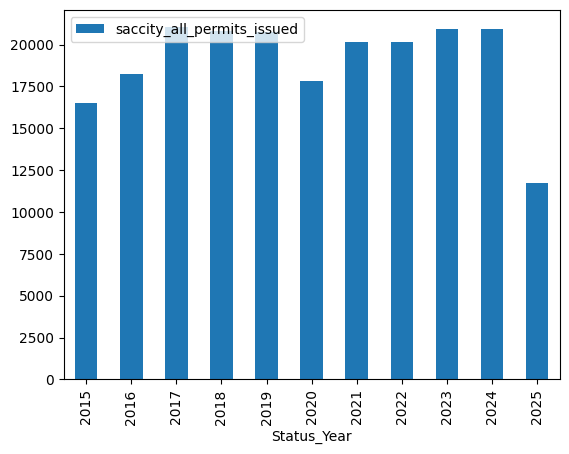

In [129]:
sql_string = """
select status_year, count(*) as saccity_all_permits_issued
from permits_saccity
group by status_year
order by status_year asc
"""
permits_saccity_by_year = duckdb.query(sql_string).df()
permits_saccity_by_year.plot(x='Status_Year', y=['saccity_all_permits_issued'], kind='bar')

<br><br><br>

# [Sac] Annotate permits with ADU hints

In [130]:
sql_string = """
SELECT *,
  
    Type in (
        'Residential'
    ) and Sub_Type in (
        'New Building'
    ) and Category in (
        'Single Family'
    ) and (
        Work_Desc ilike '%shelf-ready%adu%'
        or Work_Desc ilike '%shelf ready%adu%'
        or Work_Desc ilike '%shelf ready plans%'
        or Work_Desc ilike '%shelf made adu%'
        or Project_Name ilike '%shelf-ready%adu%'
        or Project_Name ilike '%shelf ready%adu%'
        or Project_Name ilike '%shelf ready plans%'
        or Project_Name ilike '%shelf made adu%'
    ) as certainly_shelf_ready_adu,
    
FROM permits_saccity
"""

permits_saccity = duckdb.query(sql_string).df()

<br><br><br>

# [Sac] Plot Shelf-ready ADUs

<Axes: xlabel='Status_Year'>

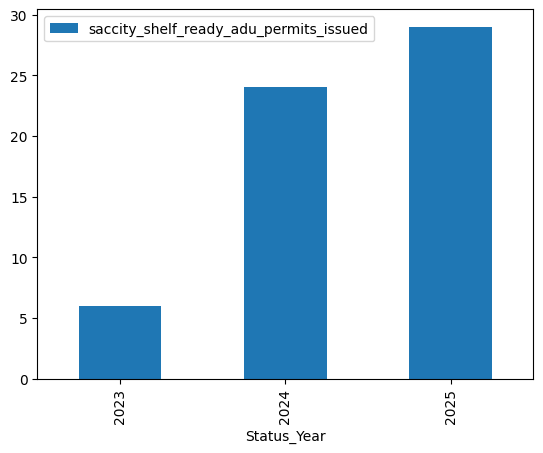

In [132]:
sql_string = """
SELECT Status_Year, count(*) as saccity_shelf_ready_adu_permits_issued
FROM permits_saccity
WHERE certainly_shelf_ready_adu
group by Status_Year 
having saccity_shelf_ready_adu_permits_issued > 1
order by Status_Year 
"""

saccity_shelf_ready_adu_permits_issued_by_year = duckdb.query(sql_string).df()
saccity_shelf_ready_adu_permits_issued_by_year.plot(
    x='Status_Year',
    y=['saccity_shelf_ready_adu_permits_issued'],
    kind='bar',
)

In [138]:
sql_string = """
SELECT status_year, work_desc
FROM permits_saccity
WHERE work_desc ilike '%adu%'
  and work_desc ilike '%shared plans%'
  and not certainly_shelf_ready_adu
  and status_year >= 2023
"""

adu_permits_issued_digging = duckdb.query(sql_string).df()
with pd.option_context('display.max_rows', 100, 'display.max_columns', None, 'display.max_colwidth', 400):
    display(adu_permits_issued_digging.sample(n=10))

,Status_Year,Work_Desc
47,2024,"EPC - SHARED PLANS under permit RES-2325357- This permit is for new construction of building 1E. 2-story building. Total building is 904 SF. Ground floor unit is 443 SF. Upper floor unit is 461 SF. Construction Type: VB, Occupancy type: R-3.\r\n\r\nFull project consists of new construction of (9) 2-story buildings. Each building has one unit on each level, total of (2) units per building. (18)..."
5,2023,"EPC - SHARED PLANS (2) WITH RES-2222167 : NEW 309 S.F. STUDIO DETACHED ADU WITH MINI SPLIT & TANKLESS GAS FIRED WATER HEATER. WILL SHARE GAS, ELECTRICAL, WATER & SEWER SERVICE WITH SFR.\r\n6.4kW PV SOLAR\r\n$61,800 ADU, $21,120 PV SOLAR\r\nDETACHED GARAGE DEMO UNDER RES-2204258\r\nCarbon monoxide & Smoke alarms required. Reference CRC sections R315 & R314, Water conserving fixtures are require..."
76,2025,PERMIT TO OBTAIN FINALS ON RES-2212598 EPC - SHARED PLANS (2) 350SF ADU ADDITION TO EXISTING RESIDENCE TO CREATE A DUPLEX Shared plans reviewed under RES-2212596 Shared plans reviewed under RES-2212598
68,2024,"EPC - UNIT #3, 1 bed, 1 bath 377 Sq Ft detached ADU. Participating in SMUD Solar Share. Carbon monoxide & Smoke alarms required. Reference CRC sections R315 & R314, Water conserving fixtures are required to be installed throughout this residence per SB 407 (Note: Residences built after January 1, 1994 are exempt).”\r\n“Any new landscaping done on this property is to be in compliance with the C..."
42,2024,"EPC - EXPEDITED - 2 SHARED PLANS - HALF PLEXES WITH 2 UNITS - ADDRESSES 2508/2512-\r\nUNIT 1\r\nTOTAL Unit 1 ADU - 487 sq. ft.,\r\nTOTAL Unit 1 SECOND UNIT 1027 sq. ft.\r\nFirst floor 1 Bdrm ADU - 487 sq. ft., - 1st Floor Foyer 103 sq. ft., Garage 251 sq. ft., 2nd Floor : 2 Bdrm UNIT - 924 sq. ft.\r\nSOLAR 2.66 KW \r\n[Garage Demo - Separate Permit #RES-2304536] [Barn Demo-Separat..."
15,2023,EPC - 2 SHARED PLANS w/RES-2226780 \r\nNew 2-story Detached Garage: 1st floor garage 624 sqft. 2nd floor conditioned Office/gym 444 sqft. \r\nNOT TO BE USED AS ADU. NON-HABITABLE\r\n\r\nSeparate wrecking permit RES-2305542 for the existing garage. Shared plans reviewed under RES-2226766
45,2024,"EPC - SHARED PLANS - This permit is for new construction of building 1A plus site work. 2-story building. Total building is 904 SF. Ground floor unit is 443 SF. Upper floor unit is 461 SF. Construction Type: VB, Occupancy type: R-3. Includes overall site improvements, including trash enclosure, landscaping, fencing and gates. Onsite water and combined sewer taps. Shared onsite underground util..."
88,2025,"EPC - New 555 s.f. Detached ADU with 1 Bedroom and 1 Bathroom. + 54 S/F Porch/Roof Covering, + 14 S/F Utility Closet with exterior door. Total project 623 S/F. This is a Primary record of Shared Plans. PV Exempt. \r\nCarbon monoxide & Smoke alarms required. Reference CRC sections R315 & R314. Water conserving fixtures are required to be installed throughout this residence per SB 407 (Note: Res..."
66,2024,"Permit to complete work commenced under expired permit RES-2216771 - EPC - SHARED PLANS w/RES-2216777\r\nDetached 2-story Studio ADU/Garage\r\n1st floor garage 336sqft, 2nd floor studio ADU 364sqft, 2nd floor balcony w/stairs 92sqft.\r\nPV Solar 3.825kW\r\nWRECKING PERMIT TO BE ISSUED UNDER SEPARATE PERMIT FOR EXISTING GARAGE. \r\nCarbon monoxide & Smoke alarms required. Reference CRC sectio..."
44,2024,"EPC - EXPEDITED - SHARED PLANS W/ RES-2310305 - New construction of 2 ADUs (600 sq each ADU = 1200).\r\nunit 1 - 1st floor 600 sq ft. 2 BED, 1 BATH\r\nunit 2- 2nd floor 600 sq ft. 2 BED, 1 BATH\r\n\r\nparticipating in SMUD solar share. Shared plans reviewed under RES-2310305 \r\n“Any new landscaping done on this property is to be in compliance with the City’s Water Efficient Landscape Ordinan..."
